# Module 4: Bivariate analysis - 2 qualitative variables

To demonstrate the concepts in this module, we import dataset `rlanders.csv`. It contains synthetic data that was generated randomly (see [the description](../data/rlanders.md)).

In [1]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic diagram
import seaborn as sns                               # Advanced data visualisation

In [2]:
# Read dataset + data preparation
rlanders = pd.read_csv('https://raw.githubusercontent.com/HoGentTIN/dsai-en-labs/main/data/rlanders.csv').set_index(['ID'])
rlanders.Gender = rlanders.Gender.astype('category')
likert_scale = CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
rlanders.Survey = rlanders.Survey.astype(likert_scale)
# rlanders.info()
# rlanders.Survey.dtype

## Contingentietabellen en visualisatietechnieken

Stel dat we willen weten of vrouwen en mannen (variabele `Geslacht`) binnen de steekproef verschillend hebben gereageerd op een enquêtevraag met een Likert-schaal (variabele `Enquête`). 

Als de verhoudingen van de antwoorden (1 tot 5) voor vrouwen en mannen ongeveer gelijk zijn, zeggen we dat er geen verband is tussen de twee variabelen. Als er een significant verschil is, is er wel een verband. De vraag is nu natuurlijk wanneer het verschil groot genoeg is om als *significant* te worden beschouwd...

Een eerste stap is het berekenen van een contingentieschema. We voegen onmiddellijk de marginale totalen toe:

In [3]:
pd.crosstab(rlanders.Survey, rlanders.Gender, margins=True)

Gender,Female,Male,All
Survey,,,
1,0,4,4
2,17,45,62
3,23,91,114
4,12,53,65
5,0,5,5
All,52,198,250


### Geclusterd staafdiagram

Natuurlijk zegt zo'n tabel niet veel. Misschien moeten we de gegevens visualiseren.

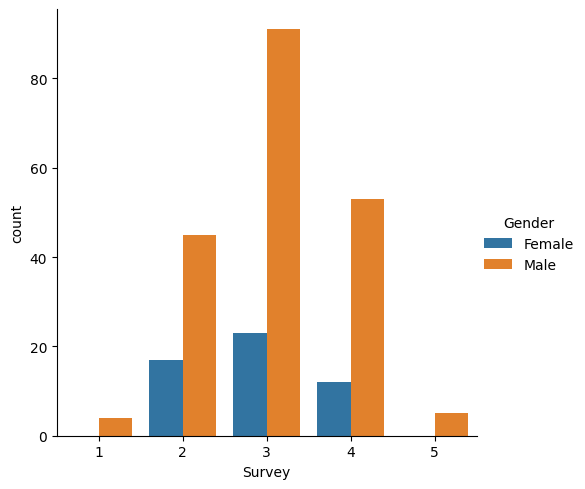

In [4]:
sns.catplot(data=rlanders, x='Survey', hue='Gender', kind='count');

Als de ‘vorm’ van de balken voor beide categorieën vergelijkbaar is, kunnen we concluderen dat beide categorieën een vergelijkbare verdeling hebben, of dat er geen verband bestaat tussen de twee variabelen. Als de vorm verschillend zou zijn (bijvoorbeeld de hoogste piek voor mannen bij 2 en voor vrouwen bij 4), zou dat erop wijzen dat er wel degelijk een verband bestaat, of dat mannen en vrouwen significant verschillende antwoorden geven op de enquêtevraag.

Opvallend is in dit geval dat de vrouwen geen extreme antwoorden (1 of 5) hebben gegeven. Er zijn echter aanzienlijk minder vrouwen in de steekproef, dus dat kan gewoon toeval zijn en hoeft niet per se een significant patroon te zijn.

### Gestapeld staafdiagram

Een andere manier om de gegevens te visualiseren is door de balken te stapelen in plaats van ze te clusteren. Helaas biedt Seaborn ons geen handige methode om dit te doen. Een crosstab-object (eigenlijk een Pandas DataFrame) heeft echter een plotmethode die we kunnen gebruiken. Merk op dat we de variabelen hebben omgewisseld bij het aanroepen van de crosstab-functie.

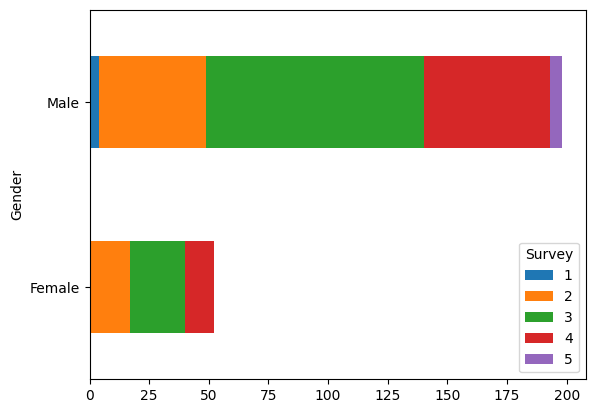

In [9]:
# Contingency table without the margins
observed = pd.crosstab(rlanders.Gender, rlanders.Survey)

# Horizontally oriented stacked bar chart
observed.plot(kind='barh', stacked=True);

We willen de verhoudingen binnen elke categorie (mannen, vrouwen) die de enquêtevraag hebben beantwoord, vergelijken. In datasets met grote verschillen in het aantal waarnemingen voor elke categorie is deze weergave nog steeds moeilijk te interpreteren. Door te kijken naar de *relatieve* frequenties (d.w.z. percentages), kunnen we een beter resultaat krijgen:

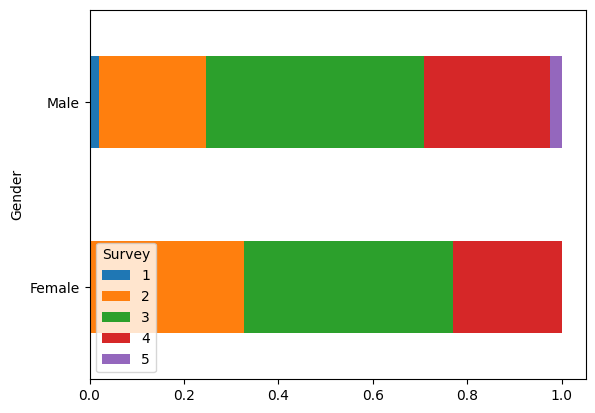

In [10]:
# Contingency table without the margins
observed_p = pd.crosstab(rlanders.Gender, rlanders.Survey, normalize='index')

# Horizontally oriented stacked bar chart
observed_p.plot(kind='barh', stacked=True);

We zien dat er enkele verschillen zijn tussen de verhoudingen, bijvoorbeeld het percentage vrouwen dat “2” (oranje) antwoordt lijkt groter dan dat van de mannen. Of dit een significant verschil is, valt nog te bezien (zie hieronder voor een verdere analyse van dit geval).

In deze weergave verliezen we de informatie over het aantal mannen en vrouwen in de steekproef. We zien namelijk niet dat er veel minder vrouwen zijn. Een mozaïekdiagram lost dit probleem op.

### Mozaïekdiagram
Een mozaïekdiagram is een grafische weergave van de kruistabel waarbij elke cel wordt weergegeven door een tegel waarvan de oppervlakte evenredig is aan de frequentie van die cel ten opzichte van het totale aantal waarnemingen.

Je kunt dit een beetje vergelijken met hoe [WinDirStat](https://windirstat.net/) de grootte van bestanden op je harde schijf visualiseert.

Voor dit geval:

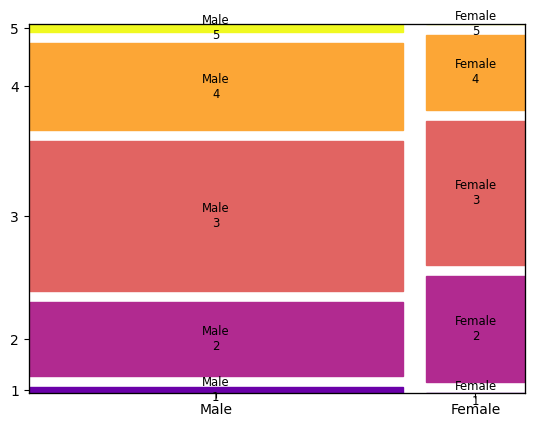

In [25]:
import matplotlib as mpl

# By default, mosaic() will color all columns the same. Here,
# we're going to give a separate color to each response (1-5).
# The response is kept in the label of each cell, a tuple of
# the two values that are represented in that cell (e.g. 
# ('Female', '2')). We will be using the "plasma" color map
# in this example.
plasma_colors = mpl.colormaps['plasma']
# Create a function that maps the cell key to the color we
# want to give it. We use the colormap function created above
# and give it a number between 0 and 1. We convert the second
# part of the key (values '1' to '5') to a number and divide
# by 5.
props = lambda key: {'color': plasma_colors(int(key[1])/5)}

mos_gender_survey = mosaic(
       data=rlanders.sort_values(by=['Survey']),
       index=['Gender', 'Survey'],
       gap=0.05, properties=props);

We kunnen hier duidelijk zien dat er meer mannen in de steekproef zitten (bredere tegels).

Je kunt ook de verdelingen van de antwoorden op de enquêtevraag vergelijken. Behalve dat de vrouwen geen extreme antwoorden (1 en 5) hebben gegeven, lijken de verdelingen op het eerste gezicht nog steeds vrij goed overeen te komen.

## Chi-kwadraat en Cramér's V

Chi-kwadraat ($\chi^2$) en Cramér's V zijn statistieken die ons kunnen helpen bepalen of er een verband bestaat tussen twee kwalitatieve (categorische) variabelen.

De redenering is als volgt: als er geen verband bestaat tussen `Geslacht` en `Enquête`, dan verwachten we dat de verhoudingen van de waarden van `Enquête` voor alle waarden van `Geslacht` gelijk zijn. Met andere woorden, zowel voor vrouwen als voor mannen zal hetzelfde percentage respondenten hetzelfde antwoord geven op de vraag.

In [5]:
observed = pd.crosstab(rlanders.Survey, rlanders.Gender)
row_sums = observed.sum(axis=1)
col_sums = observed.sum()
n = row_sums.sum()

print(row_sums)
print(col_sums)
print(f'Number of observations: {n}')

Survey
1      4
2     62
3    114
4     65
5      5
dtype: int64
Gender
Female     52
Male      198
dtype: int64
Number of observations: 250


Nu kunnen we berekenen hoe vaak we elke combinatie van `Geslacht` en `Enquête` in de steekproef kunnen verwachten. Bijvoorbeeld, 114 van de 250 respondenten antwoordden “3”, d.w.z. 114/250 = 0,456 (of 46,6%). Dan weten we dat zowel 46,6% van de vrouwen als 46,6% van de mannen “3” moet hebben geantwoord. Aangezien er 52 vrouwelijke respondenten waren, verwachten we dat 52 x 0,456 = 23,712 “3” hebben geantwoord. In werkelijkheid waren dat er 23. Voor de mannen verwachten we 198 x 0,456 = 90,288 (vergeleken met 91 in werkelijkheid).

We kunnen dit principe generaliseren naar elke cel in de tabel: $\frac{rij totaal \times kolom totaal}{n}$ (waarbij $n$ het totale aantal waarnemingen is).

De verwachte waarden kunnen worden berekend met behulp van de functie `outer()`:

In [27]:
expected = np.outer(row_sums, col_sums) / n
expected

array([[ 0.832,  3.168],
       [12.896, 49.104],
       [23.712, 90.288],
       [13.52 , 51.48 ],
       [ 1.04 ,  3.96 ]])

Let's check if the marginal totals are still correct:

In [28]:
exp_row_sums = np.sum(expected, axis=1)
exp_col_sums = np.sum(expected, axis=0)

print(f'Row totals   : {exp_row_sums}')
print(f'Column totals: {exp_col_sums}')
print(f'Observations : {exp_col_sums.sum()}')

Row totals   : [  4.  62. 114.  65.   5.]
Column totals: [ 52. 198.]
Observations : 250.0


Indeed, they do. Now, what's the difference between the expected and observed values?

In [8]:
expected - observed

Gender,Female,Male
Survey,,
1,0.832,-0.832
2,-4.104,4.104
3,0.712,-0.712
4,1.520,-1.520
5,1.040,-1.040


Sommige waargenomen waarden lijken dicht bij de verwachte waarden te liggen (bijvoorbeeld voor “3”), andere liggen verder af (bijvoorbeeld “2”). We moeten echter ook kijken naar de verschillen in verhouding.

Een maatstaf voor het bepalen van de totale afwijking in een frequentietabel is het kwadrateren van de verschillen tussen de verwachte en waargenomen waarden (net zoals men doet bij variantie/standaardafwijking) en deze te delen door de verwachte waarde:

In [29]:
diffs = (expected - observed)**2 / expected
print(diffs)

Gender    Female      Male
Survey                    
1       0.832000  0.218505
2       1.306050  0.343003
3       0.021379  0.005615
4       0.170888  0.044880
5       1.040000  0.273131


De som van al deze waarden wordt $\chi^2$ (“chi-kwadraat”) genoemd:

$\chi^2 = \sum_i \frac{(o_i - e_i)^2}{e_i}$

waarbij $o_i$ het aantal waarnemingen in de $i$'de cel van de contingentiesabel is en $e_i$ de verwachte frequentie. Vergelijk de formule met de bovenstaande code om overeenkomsten te vinden!

In [30]:
chi_squared = diffs.values.sum()
print('χ² ≈ %.3f' %chi_squared)

χ² ≈ 4.255


Nu zegt deze waarde op zich nog niet veel. Onder welke omstandigheden zeggen we dat er wel of geen verband bestaat tussen de twee variabelen? Dat hangt ook af van de grootte van de tabel en het totale aantal waarnemingen. In een contingentieschema met meer rijen/kolommen heb je een grotere $\chi^2$ nodig voordat je kunt concluderen dat er een verband bestaat.

[Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) is een formule die $\chi^2$ normaliseert tot een waarde tussen 0 en 1 die onafhankelijk is van de tabelgrootte.

$V = \sqrt{\frac{\chi^2}{n(k-1)}}$

In [31]:
dof = min(observed.shape) - 1
cramers_v = np.sqrt(chi_squared / (dof * n))
print(cramers_v)

0.13046762087242633


The value of Cramér's $V$ can also be calculated with the following Python function (from the `scipy.stats` module):

In [34]:
stats.contingency.association(observed, method='cramer')

0.13046762087242636

Om een conclusie te trekken uit deze figuur, vergelijk deze met de waarden in de onderstaande tabel:

| Cramér's V | Interpretatie          |
| :---:      | :---                    |
| 0          | Geen verband          |
| 0,1        | Zwak verband        |
| 0,25       | Matig verband    |
| 0,50       | Sterk verband      |
| 0,75       | Zeer sterk verband |
| 1          | Volledig verband    |

Ons resultaat voor Cramér's V wijst dus op een vrij zwak verband. Merk op dat Cramér's V in bepaalde gevallen te optimistisch is over het verband tussen twee variabelen. Er bestaat een aangepaste formule om deze vertekening te elimineren, maar die valt buiten het bestek van deze cursus.

Er is echter een andere manier om te bepalen of de chi-kwadraat groot genoeg is om te concluderen dat er een verband bestaat, namelijk door middel van een statistische test.

## De chi-kwadraattoets voor onafhankelijkheid

Om de vraag te beantwoorden wanneer de waarde van chi-kwadraat voldoende is om een verband tussen twee variabelen aan te nemen, kunnen we de *chi-kwadraattoets voor onafhankelijkheid* gebruiken.

### De chi-kwadraatverdeling 

De waarde van $\chi^2$ volgt een specifieke stochastische verdeling die de $\chi^2$-verdeling wordt genoemd. Net als bij de Student-t-verdeling hangt de vorm van de kansdichtheidsfunctie af van de vrijheidsgraden, die in deze context $df = (r-1)\times(k-1)$ zijn (waarbij $r$ het aantal rijen in de contingentiesabel is en $k$ het aantal kolommen).

De onderstaande code plot de kansdichtheidsfunctie van de $\chi^2$-verdeling voor een aantal vrijheidsgraden:

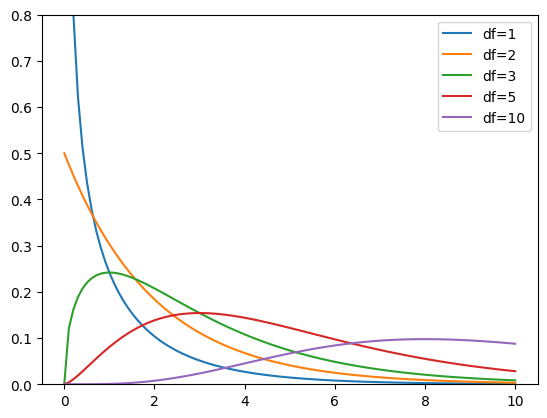

In [36]:
# Plot of the chi-squared distribution for different degrees of freedom
x = np.linspace(0, 10, num=100)
fig, tplot = plt.subplots(1, 1);
tplot.set_ylim([0, 0.8]);
tplot.plot(x, stats.chi2.pdf(x, 1), label="df=1");
tplot.plot(x, stats.chi2.pdf(x, 2), label="df=2");
tplot.plot(x, stats.chi2.pdf(x, 3), label="df=3");
tplot.plot(x, stats.chi2.pdf(x, 5), label="df=5");
tplot.plot(x, stats.chi2.pdf(x, 10), label="df=10");
tplot.legend(loc='best');

Aan de hand van deze figuur kunt u een redenering volgen die vergelijkbaar is met een z-toets aan de rechterkant. U kunt een kritische waarde $g$ berekenen waarvoor het gebied onder de curve rechts van $g$ gelijk is aan het door ons gekozen significantieniveau $\alpha$. Als de teststatistiek $\chi^2$ groter is dan $g$, zeggen we dat de afwijkingen van de verwachte waarden in de contingentiesabel te groot zijn om toeval te zijn en dat we reden hebben om aan te nemen dat er een verband bestaat tussen de twee variabelen.

U kunt ook de overtollige waarschijnlijkheid $p$ berekenen, d.w.z. de waarschijnlijkheid dat de afwijkingen die u in de steekproef ziet, het gevolg zijn van willekeurige steekproeffouten. Hiervoor berekent u het gebied onder de dichtheidscurve rechts van $p$. Als dit gebied kleiner is dan $\alpha$, zeggen we ook dat de afwijkingen te groot zijn om te worden veroorzaakt door willekeurige steekproeffouten en dat er dus een verband bestaat tussen de variabelen.

In Python gebruiken we hiervoor de volgende Scipy-functies:

- `stats.chi2.sf(x)` - de rechterstaartkans van `x` (of overlevingsfunctie)
- `stats.chi2.isf(q)` - de inverse functie van `sf(x)`, d.w.z. bereken een getal `x` waarvoor de rechterstaartkans precies `q` is.

Een grafiek voor het geval waarin $\alpha = 0,05$ (een vaak gekozen waarde voor het significantieniveau) en 4 vrijheidsgraden:

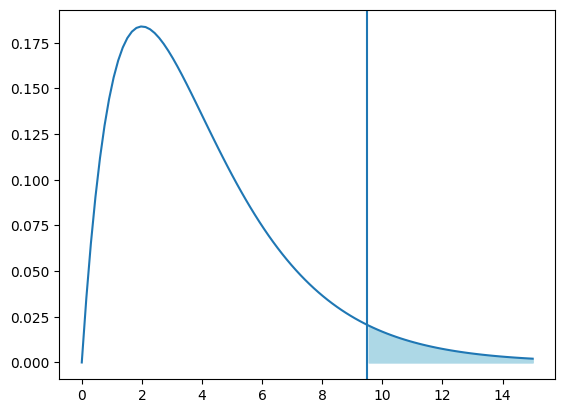

In [6]:
# Right tail probability in the chi-squared distribution

# x-values:
x = np.linspace(0, 15, num=100)
# probability density of the chi-squared distribution with 4 degrees of freedom
y = stats.chi2.pdf(x, df=4)
# the number q for which the right tail probability is exactly 5%:
q = stats.chi2.isf(.05, df=4)

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                      # probability density
tplot.fill_between(x, y, where=x>=q,  # critical area
    color='lightblue')
tplot.axvline(q);                     # critical value

### Testprocedure

Formeel verloopt de procedure van de $\chi^2$-test voor onafhankelijkheid als volgt:

1. Formuleer de hypothesen:
   - $H_0$: Er is geen verband tussen de variabelen (de verschillen tussen waargenomen en verwachte waarden zijn klein)
   - $H_1$: Er is een verband tussen de variabelen (de verschillen zijn groot)
2. Kies het significantieniveau $\alpha$
3. Bereken de waarde van de teststatistiek in de steekproef (hier: $\chi^2$).
4. Gebruik een van de volgende methoden (gebaseerd op de vrijheidsgraden $df = (r-1) \times (k-1)$):
   1. Bepaal de kritische waarde $g$ zodat $P(\chi^2 > g) = \alpha$
   2. Bereken de $p$-waarde
5. Trek een conclusie op basis van het resultaat:
   1. $\chi^2 < g$: verwerp $H_0$ niet; $\chi^2 > g$: verwerp $H_0$
   2. $p > \alpha$: verwerp $H_0$ niet; $p < \alpha$: verwerp $H_0$

In Python kunnen we dit als volgt berekenen:

In [7]:
alpha = .05
dimensions = observed.shape
dof = (dimensions[0]-1) * (dimensions[1]-1)

print("Chi-squared        : %.4f" % chi_squared)
print("Degrees of freedom : %d" % dof)

# Calculate critical value
g = stats.chi2.isf(alpha, df = dof)
print("Critical value     : %.4f" % g)

# Calculate p-value
p = stats.chi2.sf(chi_squared, df=dof)
print("p-value            : %.4f" % p)

NameError: name 'chi_squared' is not defined

Eigenlijk hoeven we deze formules niet uit het hoofd te leren om chi-kwadraat, de kritische waarde en de p-waarde te bepalen. SciPy heeft al een functie waarmee we chi-kwadraat en p-waarde rechtstreeks uit een contingentieschema kunnen berekenen:

In [14]:
# Chi-squared test for independence based on a contingency table
observed = pd.crosstab(rlanders.Survey, rlanders.Gender)
chi2, p, df, expected = stats.chi2_contingency(observed)

print("Chi-squared       : %.4f" % chi2)
print("Degrees of freedom: %d" % df)
print("P-value           : %.4f" % p)

Chi-squared       : 4.2555
Degrees of freedom: 4
P-value           : 0.3725


Zoals u kunt zien, is het resultaat voor de $p$-waarde hetzelfde als in onze uitgewerkte berekeningen!

Een grafische weergave van ons geval:

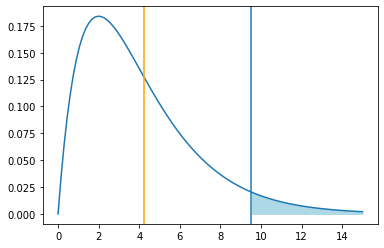

In [15]:
# Is there an association between Gender and Survey?

# x-values:
x = np.linspace(0, 15, num=100)
# probability density of the chi-squared distribution with 4 degrees of freedom
y = stats.chi2.pdf(x, df=dof)
# the number q for which the right tail probability is exactly 5%:
q = stats.chi2.isf(alpha, df=4)  # TODO: CHECK this!

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # probability density
tplot.fill_between(x, y, where=x>=q, # critical area
    color='lightblue')
tplot.axvline(q)                     # critical value
tplot.axvline(chi2, color='orange')  # chi-squared

We zien dat $\chi^2$ ruim binnen het acceptatiegebied ligt. De $p$-waarde is ook groter dan $\alpha$. Bijgevolg kunnen we de nulhypothese niet verwerpen en concluderen we dat er op basis van deze steekproef geen reden is om aan te nemen dat er een significant verschil bestaat tussen de antwoorden van vrouwen en mannen op de enquêtevraag.

## Goodness-of-fit-test

Stel dat we in een steekproef van superhelden bijhouden welk type ze zijn en dat we ook weten hoe vaak elk type voorkomt in de gehele populatie (als percentage). Hieronder staan de absolute frequenties in de steekproef $o_i$ en de verwachte relatieve frequenties $\pi_i$ in de populatie:

In [9]:
types =               ['mutant', 'human', 'alien', 'god', 'demon']
observed =   np.array([   127,      75,      98,     27,     73])
expected_p = np.array([   .35,     .17,     .23,    .08,    .17])

De vraag is nu: is deze steekproef representatief voor de populatie? Komt elk type in de steekproef voor in verhouding tot het verwachte percentage in de populatie als geheel?

### Testprocedure

Om dit soort vragen te beantwoorden, is een goodness-of-fit-test geschikt. De procedure is als volgt:

1. Formuleer de hypothesen:
- $H_0$: De steekproef is representatief voor de populatie, d.w.z. de frequentie van elke klasse binnen de steekproef komt goed overeen met die in de populatie.
   - $H_1$: De steekproef is *niet* representatief voor de populatie, d.w.z. de verschillen met de verwachte frequenties zijn te groot.
2. Kies het significantieniveau $\alpha$
3. Bereken de waarde van de teststatistiek in de steekproef (hier: $\chi^2$).
4. Gebruik een van de volgende methoden (gebaseerd op de vrijheidsgraden $df = (k-1)$ met $k$ het aantal categorieën in de steekproef):
   1. Bepaal de kritische waarde $g$ zodat $P(\chi^2 > g) = \alpha$
   2. Bereken de $p$-waarde
5. Trek een conclusie op basis van het resultaat:
   1. $\chi^2 < g$: verwerp $H_0$ niet; $\chi^2 > g$: verwerp $H_0$
   2. $p > \alpha$: verwerp $H_0$ niet; $p < \alpha$: verwerp $H_0$

Een grafiek van dit geval, inclusief de berekening van $p$ en $g$:

In [8]:
alpha = 0.05               # Significance level
n = sum(observed)          # Sample size
k = len(observed)          # Number of categories
dof = k - 1                # Degrees of freedom
expected = expected_p * n  # Expected absolute frequencies in the sample
g = stats.chi2.isf(alpha, df=dof)  # Critical value

# Goodness-of-fit-test in Python:
chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)

print("Significance level  ⍺ = %.2f" % alpha)
print("Sample size         n = %d" % n)
print("k = %d; df = %d" % (k, dof))
print("Chi-squared        χ² = %.4f" % chi2)
print("Critical value      g = %.4f" % g)
print("p-value             p = %.4f" % p)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

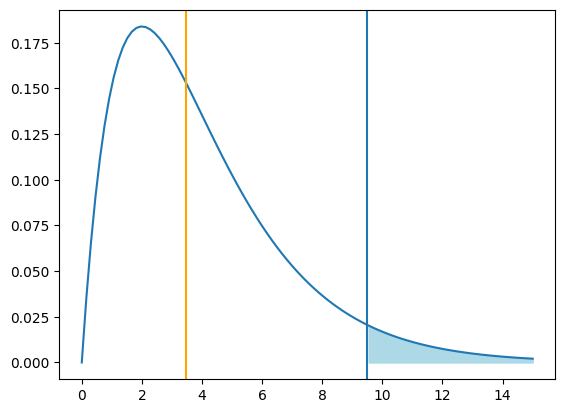

In [41]:
# Plot of the case:
# x-values:
x = np.linspace(0, 15, num=100)
# probability density of the chi-squared distribution with 4 degrees of freedom
y = stats.chi2.pdf(x, df=dof)
# the number q for which the right tail probability is exactly 5%:
q = stats.chi2.isf(alpha, df=dof)

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # probability density
tplot.fill_between(x, y, where=x>=q, # critical area
    color='lightblue')
tplot.axvline(q)                     # critical value
tplot.axvline(chi2, color='orange'); # chi-squared

We zien dat $\chi^2$ in de steekproef links van de kritische waarde ligt, dus binnen het acceptatiegebied. Daarom kunnen we de nulhypothese niet verwerpen en concluderen dat de steekproef representatief is voor de populatie, althans wat betreft de soorten superhelden.

## Gestandaardiseerde residuen

Na het uitvoeren van een chi-kwadraattoets is het vaak ook interessant om te weten in welke categorieën de grootste afwijkingen voorkomen. Je zou kunnen kijken naar de waarde $\frac{(o-e)^2}{e}$ voor elke cel in de contingentieschema (of vector), die wordt gebruikt bij de berekening van $\chi^2$. Hieruit kun je echter niet opmaken in hoeverre de afwijkingen echt als “extreem” kunnen worden beschouwd. Hiervoor gebruiken we zogenaamde *gestandaardiseerde residuen*.

We introduceren dit concept aan de hand van een voorbeeld:

Stel dat een bepaald onderzoek kijkt naar gezinnen met 5 kinderen. Er wordt een steekproef genomen van 1022 gezinnen, die worden ingedeeld in categorieën op basis van het aantal jongens in het gezin. De frequenties worden hieronder weergegeven in een Pandas DataFrame dat we handmatig zullen aanmaken en systematisch zullen uitbreiden.

In [42]:
# Data frame with 2 columns:
#  - number of boys in the family (index)
#  - number of families in the sample with that number of boys
families = pd.DataFrame(
    np.array(
        [[0,  58],
         [1, 149],
         [2, 305],
         [3, 303],
         [4, 162],
         [5,  45]]),
    columns=['num_boys', "observed"])
families.set_index(['num_boys'])
n = families.observed.sum() # sample size

Wat is nu het verwachte aantal gezinnen met het gegeven aantal jongens? Laten we aannemen dat de kans op het krijgen van jongens of meisjes even groot is, namelijk 0,5. In dat geval kunnen we de verwachte relatieve frequenties berekenen met deze formule:

$\pi_i = (0,5)^i (1-0,5)^{5-i} \binom{5}{i}$

Waarom dat zo is, is niet relevant voor het onderwerp dat we hier behandelen en valt buiten het bestek van deze cursus.

De verwachte absolute frequenties in de steekproef kunnen dan worden berekend als $e_i = n \pi_i$.

We passen dit toe op ons geval:

In [43]:
from scipy.special import binom # binomial-function

# probability for a boy
prob_boy = .5
# Add new colum to the data frame for the expected percentages
families['expected_p'] = binom(5, families.num_boys) * prob_boy**families.num_boys * prob_boy**(5-families.num_boys)
# Expected absolute frequencies in the sample:
families['expected'] = families['expected_p'] * n
families

,num_boys,observed,expected_p,expected
0,0,58,0.03125,31.9375
1,1,149,0.15625,159.6875
2,2,305,0.31250,319.3750
3,3,303,0.31250,319.3750
4,4,162,0.15625,159.6875
5,5,45,0.03125,31.9375


We perform the chi-squared goodness-of-fit test with significance level $\alpha = 0.01$.

In [44]:
alpha=0.01                         # significance level
dof=len(families)-1                # degrees of freedom
g = stats.chi2.isf(alpha, df=dof)  # Critical value
# Perform Chi-squared test, calculate χ² and p
chi2, p = stats.chisquare(f_obs=families.observed, f_exp=families.expected)

print("Chi-squared   χ² = %.4f" % chi2)
print("Critical value g = %.4f" % g)
print("p-value        p = %f"   % p)

Chi-squared   χ² = 28.8462
Critical value g = 15.0863
p-value        p = 0.000025


Dit is een zeer kleine p-waarde. De chi-kwadraat ligt ook rechts van de kritische waarde. Dit betekent dat we de nulhypothese kunnen verwerpen. Een grafiek:

NameError: name 'chi2' is not defined

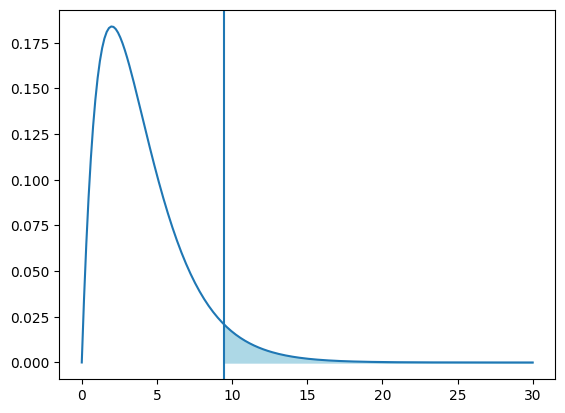

In [10]:
# x-values:
x = np.linspace(0, 30, num=200)
# probability density of the chi-squared distribution
y = stats.chi2.pdf(x, df=dof)
# the number q for which the right tail probability is exactly 1%:
q = stats.chi2.isf(alpha, df=4)  # TODO: CHECK this!

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # probability density
tplot.fill_between(x, y, where=x>=q, # critical area
    color='lightblue')
tplot.axvline(q)                     # critical value
tplot.axvline(chi2, color='orange'); # chi-squared

We concluderen dat deze steekproef NIET representatief is voor de populatie!

De formule voor het berekenen van gestandaardiseerde residuen is:

$r_i = \frac{o_i-e_i}{\sqrt{e_i (1-\pi_i)}}$

We voegen deze toe aan ons gegevensframe in een nieuwe kolom:

In [47]:
families['stdres'] = (families.observed - families.expected) / np.sqrt(families.expected * (1 - families.expected_p))
families

,num_boys,observed,expected_p,expected,stdres
0,0,58,0.03125,31.9375,4.685541
1,1,149,0.15625,159.6875,-0.920733
2,2,305,0.31250,319.3750,-0.970110
3,3,303,0.31250,319.3750,-1.105082
4,4,162,0.15625,159.6875,0.199223
5,5,45,0.03125,31.9375,2.348389


Gestandaardiseerde residuen zijn een maatstaf voor de mate waarin een bepaalde categorie over- of ondervertegenwoordigd is in de steekproef. Een waarde van 0 wordt gegeven wanneer de waargenomen frequentie gelijk is aan de verwachte frequentie. Een negatieve waarde wordt gegeven wanneer er minder waarnemingen zijn dan verwacht en een positieve waarde wanneer er meer zijn. Zolang $r_i \in [-2, 2]$, beschouwen we de verschillen als willekeurige steekproeffouten. Een waarde $r_i < -2$ duidt op ondervertegenwoordiging van deze categorie, $r_i > 2$ duidt op oververtegenwoordiging.

Gezinnen met alleen meisjes en alleen jongens zijn dus oververtegenwoordigd in de steekproef. In de praktijk kunnen onderzoekers ervoor kiezen om willekeurig een aantal waarnemingen in deze categorieën uit het onderzoek te verwijderen, zodat de steekproef representatief wordt voor de populatie.

Merk op dat er een manier is om gestandaardiseerde residuen te berekenen met behulp van [`statsmodels.stats.contingency_tables.Table`](https://www.statsmodels.org/stable/generated/statsmodels.stats.contingency_tables.Table.html#statsmodels.stats.contingency_tables.Table). However, that only works with [contingency tables for two variables](https://www.statsmodels.org/stable/contingency_tables.html?highlight=residuals), not for this case with one variable.

## De regel van Cochran

Een chi-kwadraattoets kan alleen goede resultaten opleveren als u voldoende waarnemingen in elke categorie hebt. De statisticus Cochran (1954) formuleerde een vuistregel om te bepalen wat precies *voldoende* is voor contingentieschema's groter dan 2x2:

- Alle verwachte waarden moeten minimaal 1 zijn
- Maximaal 20% van de verwachte waarden mag kleiner zijn dan 5